In [1]:
import torch

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root = './mnist_data', train = True, download=True, transform=transform)
test_dataset = datasets.MNIST(root = './mnist_data', train = False, download=True, transform=transform)

torch.Size([1, 28, 28])
1


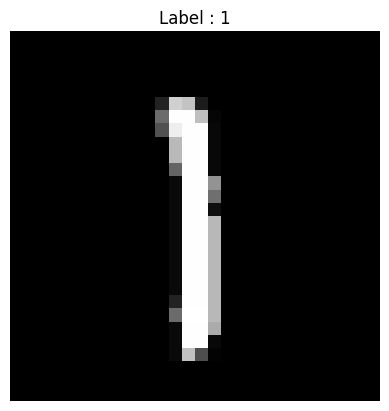

In [3]:
import matplotlib.pyplot as plt
import random

sample_idx = random.randint(0, len(train_dataset)-1)

image, label = train_dataset[sample_idx]
print(image.shape)
print(label)

plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(f'Label : {label}')
plt.axis('off')
plt.show()

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle= False)

In [5]:
class MLP(nn.Module):
    def __init__(self,input_dim, output_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

        self.linear_1 = nn.Linear(input_dim, 256)
        self.linear_2 = nn.Linear(256, 128)
        self.linear_3 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  
        self.output = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.linear_1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_2(x))
        x = self.dropout(x)
        x = self.relu(self.linear_3(x))
        return self.output(x)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 64 * 14 * 14 
target_cnt = 10
model = MLP(image_size, target_cnt).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
num_epoch = 5
patience = 3
cnt = 0
best_acc = 0
for epoch in range(num_epoch+1):
    model.train()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        pred = model(data)
        optimizer.zero_grad()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        for test_data, test_target in test_loader:
            test_data, test_target = test_data.to(device), test_target.to(device)
            test_pred = model(test_data)
            pred_target = torch.argmax(test_pred, axis = 1)
            acc = (pred_target == test_target).float().mean()


            
        if acc > best_acc :
            best_acc = acc
            cnt = 0
            torch.save(model.state_dict(),"best_model.pt")
        else :
            cnt += 1
        if cnt >= patience:
            print('조기종료')    
            break;
    print(f'{epoch:4d}/{num_epoch} Epoch | Test Accuracy : {acc * 100:.2f}%')
    

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x784 and 12544x256)